In [1]:
# libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import math
from tqdm import tqdm
import numpy as np
from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator
import sacrebleu
import time
import matplotlib.pyplot as plt

In [2]:
# train on GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.get_device_name())
'''
Note:
assert len(train_iterator) % batch_size == 0
or notebook will return tensor dimension mismatch when training the last batch
in this notebook len(train_iterator) == 29000, so there will be 580 batches
'''
batch_size = 50 # I tried several batch sizes, this does not return 'CUDA out of memory'

GeForce MX150


In [3]:
# loading data and word preprocessing using spaCy
german_text = Field(tokenize = "spacy", 
                    tokenizer_language="de", 
                    init_token = '<sos>', 
                    eos_token = '<eos>', 
                    lower = True)
english_text = Field(tokenize = "spacy", 
                     tokenizer_language="en", 
                     init_token = '<sos>', 
                     eos_token = '<eos>', 
                     lower = True)
train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), fields = (german_text, english_text))
print(german_text.preprocess('der mann trinkt bier'))
print(f"Training set length: {len(train_data.examples)}")
german_text.build_vocab(train_data, min_freq = 4)
english_text.build_vocab(train_data, min_freq = 4)
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), batch_size = batch_size, device = device)
print(f'Number of training batches: {len(train_iterator)}')
assert(len(train_iterator) % batch_size == 0, 'Possible tensor dimension mismatch error while training, consider changing batch size.')

<>:20: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:20: SyntaxWarning: assertion is always true, perhaps remove parentheses?


['der', 'mann', 'trinkt', 'bier']
Training set length: 29000
Number of training batches: 580


<ipython-input-3-0d62185da844>:20: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(len(train_iterator) % batch_size == 0, 'Possible tensor dimension mismatch error while training, consider changing batch size.')


In [4]:
# a random example in the test set
random_index = random.randint(0, len(test_data.examples))
ger_example = vars(test_data.examples[random_index])['src']
eng_example = vars(test_data.examples[random_index])['trg']
print("German example:", " ".join(ger_example))
print("English example:", " ".join(eng_example))

German example: eine blondine hält mit einem mann im sand händchen .
English example: a blond holding hands with a guy in the sand .


In [5]:
# encoder
class German_Encoder(nn.Module):
    def __init__(self, dimensions, layers):
        super(German_Encoder, self).__init__()
        
        self.input_dim = dimensions['input']
        self.embedding_dim = dimensions['embedding']
        self.hidden_dim = dimensions['hidden']
        self.layers = layers
        
        self.embedding = nn.Embedding(self.input_dim, self.embedding_dim, padding_idx=1)
        self.dropout = nn.Dropout(0.25)
        self.lstm = nn.LSTM(self.embedding_dim, self.hidden_dim, layers, dropout=0.25, bias=False, batch_first=True, bidirectional=True)
        self.ff = nn.Sequential(
            nn.Linear(self.hidden_dim*2, self.hidden_dim),
            nn.Tanh()
        )
        
    def forward(self, x):
        x = self.embedding(x.permute(1, 0))
        x = self.dropout(x)
        outputs, (hidden_state, cell_state) = self.lstm(x)
        forward_hidden, backward_hidden = hidden_state[0::2,:,:], hidden_state[1::2,:,:]
        forward_cell, backward_cell = cell_state[0::2,:,:], cell_state[1::2,:,:]
        
        h_n = torch.cat((forward_hidden, backward_hidden), dim=-1)
        c_n = torch.cat((forward_cell, backward_cell), dim=-1)
        h_n, c_n = self.ff(h_n), self.ff(c_n)
        return outputs, (h_n, c_n)

In [6]:
# attention model
class Calculate_Attention(nn.Module):
    def __init__(self, dimensions):
        super(Calculate_Attention, self).__init__()
        self.hidden_dim = dimensions['hidden']
        
        self.W = nn.Linear(3 * self.hidden_dim, self.hidden_dim)
        self.v = nn.Linear(self.hidden_dim, 1, bias=False)

    def forward(self, dec_hidden, enc_outputs):
#         print(dec_hidden.shape)
#         print(enc_outputs.shape)
        dec_hidden = dec_hidden.permute(1, 0, 2)
        dec_hidden = dec_hidden.repeat(1, enc_outputs.shape[1], 1)
        concat = torch.cat((dec_hidden, enc_outputs), dim=2)
        energy = torch.tanh(self.W(concat))
        
        attention = F.softmax(self.v(energy).squeeze(2), dim=1)
        
        return attention

In [7]:
# decoder
class English_Decoder(nn.Module):
    def __init__(self, dimensions, layers):
        super(English_Decoder, self).__init__()
        
        self.output_dim = dimensions['output']
        self.embedding_dim = dimensions['embedding']
        self.hidden_dim = dimensions['hidden']
        self.layers = layers
        
        self.dropout = nn.Dropout(0.25)
        self.embedding = nn.Embedding(self.output_dim, self.embedding_dim, padding_idx=1)
        self.attention = Calculate_Attention(dimensions)
        self.lstm = nn.LSTM(self.embedding_dim + 2*self.hidden_dim, self.hidden_dim, self.layers, dropout=0.1, batch_first=True)
        self.ff = nn.Sequential(
            nn.Linear(3*self.hidden_dim + self.embedding_dim, self.embedding_dim),
            nn.Tanh()
        )
        self.output_layer = nn.Linear(self.embedding_dim, self.output_dim)
        
    def forward(self, x, hidden, enc_outputs):
        x = self.embedding(x.unsqueeze(1))
        x_embed = self.dropout(x)
        attention_score = self.attention(hidden[0], enc_outputs).unsqueeze(1)
        context = torch.bmm(attention_score, enc_outputs)
        
        rnn_inputs = torch.cat((x_embed, context), dim=2)
        output, hidden = self.lstm(rnn_inputs, hidden)
        output = self.ff(torch.cat((output, context, x_embed), dim=2))
        output = self.output_layer(output).squeeze(1)
        attention_return = attention_score.squeeze(1)
        return output, hidden, attention_return

In [8]:
# seq2seq model
class Machine_Translation_Model(nn.Module):
    def __init__(self, encoder, decoder):
        super(Machine_Translation_Model, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, german, english, learning=True):
        sentence_len = english.shape[0]
        output_dim = self.decoder.output_dim
        
        outputs = torch.zeros(sentence_len, batch_size, output_dim).to(device)
        
        enc_outputs, hidden_states = self.encoder(german)
        
        dec_output = english[0,:]
        for t in range(1, sentence_len):
            dec_output, hidden, _ = self.decoder(dec_output, hidden_states, enc_outputs)

            outputs[t] = dec_output
            
            pred_next = dec_output.argmax(1)
            
            if learning and random.random() < 0.5:
                dec_output = english[t]
            else:
                dec_output = pred_next
        return outputs
    
    def translate(self, input_tensor):
        input_tensor.to(device)
        
        outputs = torch.zeros(50, input_tensor.shape[1]).to(device)
        attentions = torch.zeros(50, input_tensor.shape[1], input_tensor.shape[0]).to(device)
        
        enc_outputs, hidden_states = self.encoder(input_tensor)
        
        dec_output = torch.zeros(input_tensor.shape[1], dtype=torch.int64).to(device)
        dec_output.fill_(english_text.vocab.stoi['<sos>'])
        outputs[0] = dec_output
        
        for t in range(1, 50):
            dec_output, hidden, attention_score = self.decoder(dec_output, hidden_states, enc_outputs)
            attentions[t] = attention_score
            dec_output = dec_output.argmax(1)
            outputs[t] = dec_output
        return outputs, attentions

In [9]:
# train function
def train(model, iterator, optimiser, criterion, epochs, force_stop=False):
    model.train()
    start = time.time()
    losses = []
    for i in range(epochs): 
        print(f'Start training epoch {i+1} of {epochs}.')
        epoch_loss = 0
        for j, batch in tqdm(enumerate(iterator)):
            german = batch.src.to(device)
            english = batch.trg.to(device)

            optimiser.zero_grad()
            outputs = model(german, english)
        
            outputs = outputs[1:].view(-1, outputs.shape[-1])
            english = english[1:].view(-1)

            loss = criterion(outputs, english)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
            optimiser.step()
        
            epoch_loss += loss.item()
            if force_stop and j == 20:
                break
        elapsed_time = int(time.time() - start)
        elapsed_mins = int(elapsed_time/60)
        elapsed_secs = int(elapsed_time - elapsed_mins * 60)
        losses.append(epoch_loss)
        print(f'Epoch {i+1} of {epochs} complete. Epoch loss: {epoch_loss}. Time elapsed: {elapsed_mins} minutes, {elapsed_secs} seconds')
    end = time.time()
    total_duration = end - start
    total_mins = int(total_duration/60)
    total_secs = int(total_duration - 60 * total_mins)
    print(f'Training complete. Time elapsed: {total_mins} minutes, {total_secs} seconds')
    plt.figure(figsize=(16, 8))
    xaxis = [i+1 for i in range(epochs)]
    plt.plot(xaxis, losses)
    plt.title('Loss over epochs')
    plt.show()

In [10]:
# hyperparameters
dimensions = {'input': len(german_text.vocab),
             'output': len(english_text.vocab),
             'embedding': 256,
             'hidden': 512}
layers = 1
epochs = 50

enc = German_Encoder(dimensions, layers).to(device)
dec = English_Decoder(dimensions, layers).to(device)
model = Machine_Translation_Model(enc, dec).to(device)

optimiser = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=1).to(device)

C:\Users\cngzl\.conda\envs\pytorch\lib\site-packages\torch\nn\modules\rnn.py:47: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
C:\Users\cngzl\.conda\envs\pytorch\lib\site-packages\torch\nn\modules\rnn.py:47: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0it [00:00, ?it/s]

Start training epoch 1 of 50.


580it [06:04,  1.59it/s]
0it [00:00, ?it/s]

Epoch 1 of 50 complete. Epoch loss: 2623.0778691768646. Time elapsed: 6 minutes, 4 seconds
Start training epoch 2 of 50.


580it [06:03,  1.59it/s]
0it [00:00, ?it/s]

Epoch 2 of 50 complete. Epoch loss: 2168.2279255390167. Time elapsed: 12 minutes, 8 seconds
Start training epoch 3 of 50.


580it [06:05,  1.58it/s]
0it [00:00, ?it/s]

Epoch 3 of 50 complete. Epoch loss: 1965.3506200313568. Time elapsed: 18 minutes, 14 seconds
Start training epoch 4 of 50.


580it [06:06,  1.58it/s]
0it [00:00, ?it/s]

Epoch 4 of 50 complete. Epoch loss: 1824.9099490642548. Time elapsed: 24 minutes, 21 seconds
Start training epoch 5 of 50.


580it [06:08,  1.57it/s]
0it [00:00, ?it/s]

Epoch 5 of 50 complete. Epoch loss: 1722.2633941173553. Time elapsed: 30 minutes, 30 seconds
Start training epoch 6 of 50.


580it [06:11,  1.56it/s]
0it [00:00, ?it/s]

Epoch 6 of 50 complete. Epoch loss: 1636.9639930725098. Time elapsed: 36 minutes, 41 seconds
Start training epoch 7 of 50.


580it [06:09,  1.57it/s]
0it [00:00, ?it/s]

Epoch 7 of 50 complete. Epoch loss: 1564.3674008846283. Time elapsed: 42 minutes, 51 seconds
Start training epoch 8 of 50.


580it [06:12,  1.56it/s]
0it [00:00, ?it/s]

Epoch 8 of 50 complete. Epoch loss: 1497.1907048225403. Time elapsed: 49 minutes, 3 seconds
Start training epoch 9 of 50.


580it [06:12,  1.56it/s]
0it [00:00, ?it/s]

Epoch 9 of 50 complete. Epoch loss: 1434.6117143630981. Time elapsed: 55 minutes, 15 seconds
Start training epoch 10 of 50.


580it [06:12,  1.56it/s]
0it [00:00, ?it/s]

Epoch 10 of 50 complete. Epoch loss: 1385.628167271614. Time elapsed: 61 minutes, 28 seconds
Start training epoch 11 of 50.


580it [06:13,  1.55it/s]
0it [00:00, ?it/s]

Epoch 11 of 50 complete. Epoch loss: 1348.753401517868. Time elapsed: 67 minutes, 41 seconds
Start training epoch 12 of 50.


580it [06:27,  1.50it/s]
0it [00:00, ?it/s]

Epoch 12 of 50 complete. Epoch loss: 1300.9247907400131. Time elapsed: 74 minutes, 9 seconds
Start training epoch 13 of 50.


580it [06:24,  1.51it/s]
0it [00:00, ?it/s]

Epoch 13 of 50 complete. Epoch loss: 1272.3911609649658. Time elapsed: 80 minutes, 33 seconds
Start training epoch 14 of 50.


580it [06:24,  1.51it/s]
0it [00:00, ?it/s]

Epoch 14 of 50 complete. Epoch loss: 1233.1801789999008. Time elapsed: 86 minutes, 58 seconds
Start training epoch 15 of 50.


580it [06:16,  1.54it/s]
0it [00:00, ?it/s]

Epoch 15 of 50 complete. Epoch loss: 1199.919527053833. Time elapsed: 93 minutes, 15 seconds
Start training epoch 16 of 50.


580it [06:19,  1.53it/s]
0it [00:00, ?it/s]

Epoch 16 of 50 complete. Epoch loss: 1185.0555554628372. Time elapsed: 99 minutes, 34 seconds
Start training epoch 17 of 50.


580it [06:18,  1.53it/s]
0it [00:00, ?it/s]

Epoch 17 of 50 complete. Epoch loss: 1164.1193755865097. Time elapsed: 105 minutes, 53 seconds
Start training epoch 18 of 50.


580it [06:19,  1.53it/s]
0it [00:00, ?it/s]

Epoch 18 of 50 complete. Epoch loss: 1146.5450068712234. Time elapsed: 112 minutes, 12 seconds
Start training epoch 19 of 50.


580it [06:20,  1.52it/s]
0it [00:00, ?it/s]

Epoch 19 of 50 complete. Epoch loss: 1115.5808767080307. Time elapsed: 118 minutes, 33 seconds
Start training epoch 20 of 50.


580it [06:18,  1.53it/s]
0it [00:00, ?it/s]

Epoch 20 of 50 complete. Epoch loss: 1087.9848088026047. Time elapsed: 124 minutes, 51 seconds
Start training epoch 21 of 50.


580it [06:18,  1.53it/s]
0it [00:00, ?it/s]

Epoch 21 of 50 complete. Epoch loss: 1076.9182275533676. Time elapsed: 131 minutes, 9 seconds
Start training epoch 22 of 50.


580it [06:17,  1.53it/s]
0it [00:00, ?it/s]

Epoch 22 of 50 complete. Epoch loss: 1051.1438019275665. Time elapsed: 137 minutes, 27 seconds
Start training epoch 23 of 50.


580it [06:19,  1.53it/s]
0it [00:00, ?it/s]

Epoch 23 of 50 complete. Epoch loss: 1047.5525796413422. Time elapsed: 143 minutes, 47 seconds
Start training epoch 24 of 50.


580it [06:16,  1.54it/s]
0it [00:00, ?it/s]

Epoch 24 of 50 complete. Epoch loss: 1032.5792971849442. Time elapsed: 150 minutes, 4 seconds
Start training epoch 25 of 50.


580it [06:17,  1.53it/s]
0it [00:00, ?it/s]

Epoch 25 of 50 complete. Epoch loss: 1011.8877815008163. Time elapsed: 156 minutes, 22 seconds
Start training epoch 26 of 50.


580it [06:21,  1.52it/s]
0it [00:00, ?it/s]

Epoch 26 of 50 complete. Epoch loss: 1001.7963573932648. Time elapsed: 162 minutes, 43 seconds
Start training epoch 27 of 50.


580it [06:19,  1.53it/s]
0it [00:00, ?it/s]

Epoch 27 of 50 complete. Epoch loss: 989.7415992021561. Time elapsed: 169 minutes, 3 seconds
Start training epoch 28 of 50.


580it [06:16,  1.54it/s]
0it [00:00, ?it/s]

Epoch 28 of 50 complete. Epoch loss: 988.2319512367249. Time elapsed: 175 minutes, 19 seconds
Start training epoch 29 of 50.


580it [06:18,  1.53it/s]
0it [00:00, ?it/s]

Epoch 29 of 50 complete. Epoch loss: 971.7747563123703. Time elapsed: 181 minutes, 37 seconds
Start training epoch 30 of 50.


580it [06:20,  1.53it/s]
0it [00:00, ?it/s]

Epoch 30 of 50 complete. Epoch loss: 967.7264209985733. Time elapsed: 187 minutes, 57 seconds
Start training epoch 31 of 50.


580it [06:20,  1.53it/s]
0it [00:00, ?it/s]

Epoch 31 of 50 complete. Epoch loss: 945.97550791502. Time elapsed: 194 minutes, 17 seconds
Start training epoch 32 of 50.


580it [06:22,  1.52it/s]
0it [00:00, ?it/s]

Epoch 32 of 50 complete. Epoch loss: 938.5555775165558. Time elapsed: 200 minutes, 40 seconds
Start training epoch 33 of 50.


580it [06:19,  1.53it/s]
0it [00:00, ?it/s]

Epoch 33 of 50 complete. Epoch loss: 947.0901989936829. Time elapsed: 206 minutes, 59 seconds
Start training epoch 34 of 50.


580it [06:20,  1.52it/s]
0it [00:00, ?it/s]

Epoch 34 of 50 complete. Epoch loss: 929.0326473712921. Time elapsed: 213 minutes, 20 seconds
Start training epoch 35 of 50.


580it [06:19,  1.53it/s]
0it [00:00, ?it/s]

Epoch 35 of 50 complete. Epoch loss: 912.025520503521. Time elapsed: 219 minutes, 40 seconds
Start training epoch 36 of 50.


580it [06:20,  1.52it/s]
0it [00:00, ?it/s]

Epoch 36 of 50 complete. Epoch loss: 937.3617724180222. Time elapsed: 226 minutes, 0 seconds
Start training epoch 37 of 50.


580it [06:18,  1.53it/s]
0it [00:00, ?it/s]

Epoch 37 of 50 complete. Epoch loss: 895.8426998853683. Time elapsed: 232 minutes, 19 seconds
Start training epoch 38 of 50.


580it [06:20,  1.53it/s]
0it [00:00, ?it/s]

Epoch 38 of 50 complete. Epoch loss: 907.1809360384941. Time elapsed: 238 minutes, 40 seconds
Start training epoch 39 of 50.


580it [06:19,  1.53it/s]
0it [00:00, ?it/s]

Epoch 39 of 50 complete. Epoch loss: 893.3952022790909. Time elapsed: 244 minutes, 59 seconds
Start training epoch 40 of 50.


580it [06:20,  1.52it/s]
0it [00:00, ?it/s]

Epoch 40 of 50 complete. Epoch loss: 886.6013377904892. Time elapsed: 251 minutes, 19 seconds
Start training epoch 41 of 50.


580it [06:23,  1.51it/s]
0it [00:00, ?it/s]

Epoch 41 of 50 complete. Epoch loss: 867.0150805711746. Time elapsed: 257 minutes, 43 seconds
Start training epoch 42 of 50.


580it [06:19,  1.53it/s]
0it [00:00, ?it/s]

Epoch 42 of 50 complete. Epoch loss: 878.6416050195694. Time elapsed: 264 minutes, 2 seconds
Start training epoch 43 of 50.


580it [06:19,  1.53it/s]
0it [00:00, ?it/s]

Epoch 43 of 50 complete. Epoch loss: 863.6666631698608. Time elapsed: 270 minutes, 22 seconds
Start training epoch 44 of 50.


580it [06:17,  1.54it/s]
0it [00:00, ?it/s]

Epoch 44 of 50 complete. Epoch loss: 866.792387843132. Time elapsed: 276 minutes, 40 seconds
Start training epoch 45 of 50.


580it [06:20,  1.52it/s]
0it [00:00, ?it/s]

Epoch 45 of 50 complete. Epoch loss: 863.5503120422363. Time elapsed: 283 minutes, 0 seconds
Start training epoch 46 of 50.


580it [06:21,  1.52it/s]
0it [00:00, ?it/s]

Epoch 46 of 50 complete. Epoch loss: 849.7544066309929. Time elapsed: 289 minutes, 22 seconds
Start training epoch 47 of 50.


580it [06:20,  1.52it/s]
0it [00:00, ?it/s]

Epoch 47 of 50 complete. Epoch loss: 851.3227222561836. Time elapsed: 295 minutes, 43 seconds
Start training epoch 48 of 50.


580it [06:19,  1.53it/s]
0it [00:00, ?it/s]

Epoch 48 of 50 complete. Epoch loss: 843.2699930667877. Time elapsed: 302 minutes, 2 seconds
Start training epoch 49 of 50.


580it [06:22,  1.52it/s]
0it [00:00, ?it/s]

Epoch 49 of 50 complete. Epoch loss: 840.1098526120186. Time elapsed: 308 minutes, 24 seconds
Start training epoch 50 of 50.


580it [06:18,  1.53it/s]


Epoch 50 of 50 complete. Epoch loss: 841.1988242864609. Time elapsed: 314 minutes, 43 seconds
Training complete. Time elapsed: 314 minutes, 43 seconds


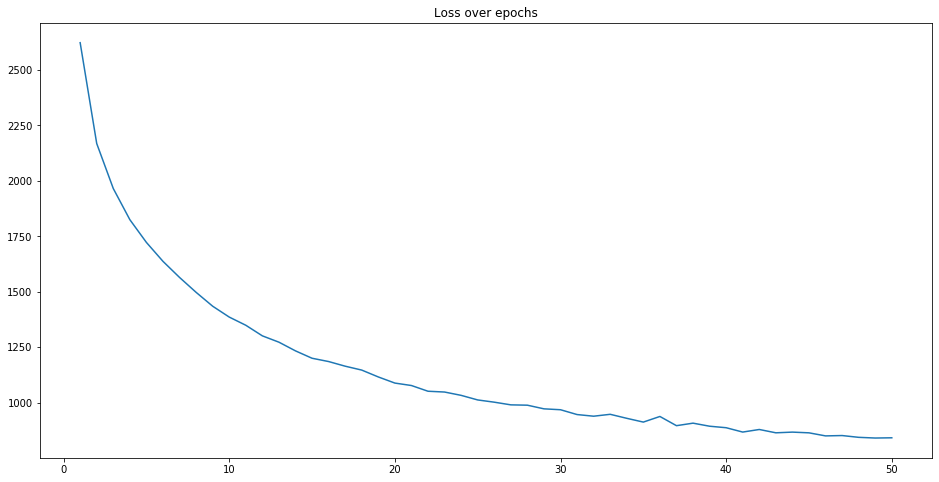

In [11]:
train(model, train_iterator, optimiser, criterion, epochs, force_stop=False)

In [12]:
# getting information on trained model
print('Model state_dict:')
for param_tensor in model.state_dict():
    print(param_tensor, '\t', model.state_dict()[param_tensor].size())
print('Optimiser state_dict:')
for var_name in optimiser.state_dict():
    print(var_name, '\t', optimiser.state_dict()[var_name])
def save_model(model):
    torch.save(model.state_dict(), 'german-english-model_50_epochs.pth')

Model state_dict:
encoder.embedding.weight 	 torch.Size([4245, 256])
encoder.lstm.weight_ih_l0 	 torch.Size([2048, 256])
encoder.lstm.weight_hh_l0 	 torch.Size([2048, 512])
encoder.lstm.weight_ih_l0_reverse 	 torch.Size([2048, 256])
encoder.lstm.weight_hh_l0_reverse 	 torch.Size([2048, 512])
encoder.ff.0.weight 	 torch.Size([512, 1024])
encoder.ff.0.bias 	 torch.Size([512])
decoder.embedding.weight 	 torch.Size([3813, 256])
decoder.attention.W.weight 	 torch.Size([512, 1536])
decoder.attention.W.bias 	 torch.Size([512])
decoder.attention.v.weight 	 torch.Size([1, 512])
decoder.lstm.weight_ih_l0 	 torch.Size([2048, 1280])
decoder.lstm.weight_hh_l0 	 torch.Size([2048, 512])
decoder.lstm.bias_ih_l0 	 torch.Size([2048])
decoder.lstm.bias_hh_l0 	 torch.Size([2048])
decoder.ff.0.weight 	 torch.Size([256, 1792])
decoder.ff.0.bias 	 torch.Size([256])
decoder.output_layer.weight 	 torch.Size([3813, 256])
decoder.output_layer.bias 	 torch.Size([3813])
Optimiser state_dict:
state 	 {2473065133312

In [13]:
# saving model
save_model(model)

In [14]:
# loading model
model.load_state_dict(torch.load('german-english-model_50_epochs.pth', map_location=device))

<All keys matched successfully>

In [27]:
def evaluate_bleu_score(model, iterator, force_stop=False):
    model.eval()
    print(f'Number of evalutation batches: {len(iterator)}')
    
    predictions = []
    ground_truths = []
    
    with torch.no_grad():
        for batch_idx, batch in tqdm(enumerate(iterator)):
            german = batch.src
            english = batch.trg
            
            outputs, _ = model.translate(german)
            
            # model predictions
            prediction = []
            for i in range(outputs.shape[1]):
                sequence = outputs[:, i]
                words = []
                for token_idx in sequence:
                    token = english_text.vocab.itos[int(token_idx)]
                    if token == '<eos>' or token == '<pad>':
                        break
                    else:
                        words.append(token)
                words = ' '.join(words)
                prediction.append(words)
            predictions += prediction
            
            # human translation
            ground_truth = []
            for i in range(english.shape[1]):
                sequence = english[:, i]
                words = []
                for token_idx in sequence:
                    token = english_text.vocab.itos[int(token_idx)]
#                     print(token)
                    if token == '<eos>' or token == '<pad>':
                        break
                    else:
                        words.append(token)
                words = ' '.join(words)
                ground_truth.append(words) 
            ground_truths += ground_truth
            
            if force_stop:
                break
    ground_truths = [ground_truths]
#     print(predictions)
#     print(ground_truths)
    score = sacrebleu.corpus_bleu(predictions, ground_truths, force=True).score
    print('BLEU score:', score)
evaluate_bleu_score(model, valid_iterator, force_stop=False)

0it [00:00, ?it/s]

Number of evalutation batches: 21


21it [00:08,  2.60it/s]


BLEU score: 11.258587695805517


In [16]:
# test model for actual translation
def translate(model, text):
    
    tokens = german_text.preprocess(text)
    input_tensor = german_text.process([tokens]).to(device)
    
    with torch.no_grad():
        outputs, attention = model.translate(input_tensor)
        output_tensor = outputs.squeeze(1)
        
        for position, token_idx in enumerate(output_tensor):
            token = english_text.vocab.itos[int(token_idx)]
            if token == '<eos>' or token == '<pad>':
                break
        eos_position = position
        
        translated = []
        for i in range(outputs.shape[1]):
            sequence = outputs[:,i]
            words = []
            for tok_idx in sequence:
                tok_idx = int(tok_idx)
                token = english_text.vocab.itos[tok_idx]
                if token == '<eos>' or token == '<pad>':
                    break
                else:
                    words.append(token)
            words = " ".join(words)
            translated.append(words)
    print(f'Translating English: "{text}" to German: "{translated[0][5:]}"')

In [17]:
translate(model, 'der mann trinkt bier.')

Translating English: "der mann trinkt bier." to German: " the man is drinking beer ."


In [18]:
translate(model, 'die frau isst apfel.')

Translating English: "die frau isst apfel." to German: " the woman is eating ."


In [26]:
translate(model, 'die jungen spielen mit einer katze.')

Translating English: "die jungen spielen mit einer katze." to German: " the boys are playing with a cat ."


In [22]:
translate(model, 'sie kommt aus deutschland.')

Translating English: "sie kommt aus deutschland." to German: " it is coming out of <unk> ."
